In [3]:
import io

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from denseclus import DenseClus
from denseclus.categorical import extract_categorical
from denseclus.numerical import extract_numerical

SEED = 42  # random seed to set reproducibility as best we can

sns.set_style("darkgrid")
sns.set_context("notebook")

%matplotlib inline

## Data
Let's start by downloading publicly available *Census Income dataset* available at https://archive.ics.uci.edu/ml/datasets/Adult. In this dataset we have different attributes such as age, work class, education, country, race etc for each person. We also have an indicator of person's income being more than $50K a year. The prediction task is to determine whether a person makes over 50K a year.


### Data Description
Let's talk about the data. At a high level, we can see:

- There are 15 columns and around 32K rows in the training data
- 8 of the 14 features are categorical and remaining 6 are numeric

Now lets read this into a Pandas data frame and take a look.

In [31]:
s3 = boto3.client("s3")
region = boto3.session.Session().region_name

## read the data
s3.download_file(
    f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data", "adult.data"
)
df = pd.read_csv("adult.data", header=None)

## set column names
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

df[df["native-country"] == " United-States"]
df.drop(["native-country"], axis=1, inplace=True)

In [32]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
IncomeGroup       object
dtype: object

In [33]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

## Create UMAP embeddings & Fit HdbScan for Numerical and Categorical features separately

In [7]:
import hdbscan
import umap.umap_ as umap

In [8]:
default_umap_params = {
    "categorical": {
        "metric": "hamming",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
    "numerical": {
        "metric": "l2",
        "n_neighbors": 30,
        "n_components": 5,
        "min_dist": 0.0,
    },
}

hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

### Numerical features

In [42]:
numerical_df = extract_numerical(df)

In [43]:
numerical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["numerical"],
).fit(numerical_df)

In [44]:
hdb_numerical = hdbscan.HDBSCAN(**hdbscan_params).fit(numerical_umap.embedding_)

print(f"DBCV numerical score: {hdb_numerical.relative_validity_}")

DBCV numerical score: 0.5616500258667682


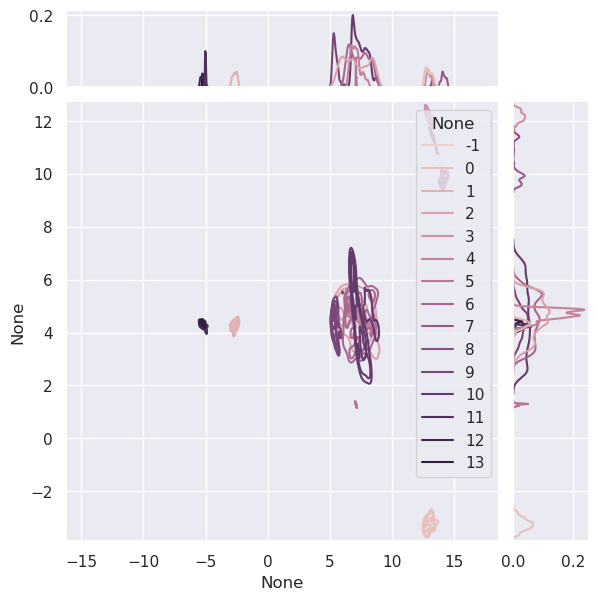

In [45]:
joint_plot = sns.jointplot( 
    x=numerical_umap.embedding_[:, 0], y=numerical_umap.embedding_[:, -1], hue=hdb_numerical.labels_, kind="kde", marginal_ticks=True)

In [52]:
numerical=df
numerical["segment"] = hdb_numerical.labels_

numerics = numerical.select_dtypes(include=[int, float]).drop(labels=["segment"], axis=1).columns.tolist()

numerical[numerics + ["segment"]].groupby(["segment"]).mean()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
segment,,,,,,
-1,43.480000,215289.480000,8.760000,0.000000,1267.840000,48.680000
0,44.532635,186190.573731,13.470588,18259.348106,0.000000,46.240935
1,42.303907,192493.143271,13.363242,0.000000,1909.367583,44.997106
2,35.570856,189133.928627,10.156581,0.000000,0.000000,38.937678
3,44.982482,193312.786861,8.947445,8791.381022,0.000000,41.748905
4,38.031300,200789.933687,5.523873,0.000000,0.000000,35.934748
5,37.972477,224083.513761,8.577982,0.000000,0.000000,38.091743
6,39.532682,186780.321316,13.258841,0.000000,0.000000,42.552085
7,41.500000,185351.024671,10.215461,8823.210526,0.000000,41.809211


From the above plot and descriptive stats generated from the clusters using only numerical features, we can see that:

- The age ranges across clusters overlap significantly. For example, cluster 0 has an average age of 44.5 while cluster 1 has an average of 42.3. These ages are quite close and the clusters likely have a lot of overlap in their age distributions. Clear separation on an important dimension like age is needed for distinct, useful clusters.

- The education levels are also very similar across many clusters. Clusters 0, 1, 6, 7, 9, 10, 11, and 12 all have average education levels between 10-13 years. There is not much differentiation on this important feature. 

- Many of the variable values like capital-gain and capital-loss are 0 for all segments. This means these variables are not helping to distinguish between clusters.

In summary, the limitations of using only these few numerical features for clustering likely results in groupings that are not very informative or useful. 

### Categorical features

In [47]:
categorical_df = extract_categorical(df)

In [48]:
categorical_umap = umap.UMAP(
    random_state=SEED,
    n_jobs=1,
    verbose=False,
    low_memory=True,
    **default_umap_params["categorical"],
).fit(categorical_df)


In [49]:
hdb_categorical = hdbscan.HDBSCAN(**hdbscan_params).fit(categorical_umap.embedding_)

print(f"DBCV categorical score: {hdb_categorical.relative_validity_}")

DBCV categorical score: 0.4123077464785735


In [50]:
n_clusters = len(np.unique(hdb_categorical.labels_))
print(f"Number of clusters: {n_clusters}")

Number of clusters: 129


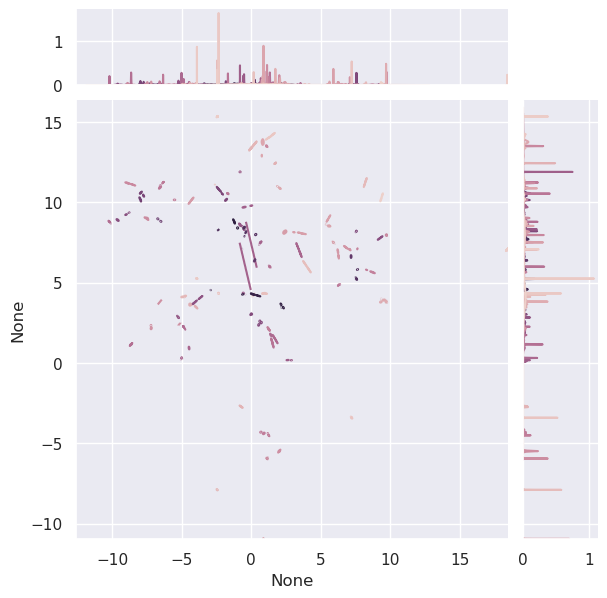

In [51]:
joint_plot = sns.jointplot( 
    x=categorical_umap.embedding_[:, 0], y=categorical_umap.embedding_[:, -1], hue=hdb_categorical.labels_, kind="kde", marginal_ticks=True)
joint_plot.ax_joint.legend_.remove()

From the above plot generated from the clusters using only categorical features, we can see that:
- 129 clusters formed from categorical leads to many clusters that are very similar to each other.
- Limited differentiation between clusters. With only categorical features, there are a finite number of possible feature combinations. This limits the granularity and differentiation between the clusters. 
- High dimensionality. Categorical features often lead to high-dimensional sparse feature spaces, which makes clustering statistically less meaningful. With 129 clusters in a sparse high-dimensional space, most of clusters have very few data points.

In summary, clustering on sole categorical features often lacks clear semantic meaning and differentiation between clusters. It tends to work better when combined with numeric features that provide more inherent structure. 

## DenseClus on all features (numerical + categorical)

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting in groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

### There are 5 methods by which you can combine embeddings spaces (param: umap_combine_method, default=intersection)

- 'intersection'
- 'union'
- 'contrast'
- 'intersection_union_mapper'
- 'ensemble'

----------
### Metric: Density Based Clustering Validation:

Density Based Clustering Validation or DBCV works for desnity-based clustering algorithms precisely because it takes noise into account and captures the shape property of clusters via densities and not distances (see the [original paper](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf))

As the paper explains, the final result of DBCV is a weighted sum of “Validity Index” values of clusters. This produces a score between -1 to 1, with the larger the value the better clustering solution.

Source: Density-Based Clustering Validation, Moulavi et al. 2014

An in depth discussion is out scope here but please see the original paper for more details.

Note that DBCV does have [drawbacks](https://github.com/scikit-learn-contrib/hdbscan/issues/283). Like all other metrics and techniques DBCV is not immune from the problems of complication and measurement in clustering as noted earlier.

However, outside of having groundtruth labels it provides an objective criteria from which to judge how well-separated density-based technique clusters are.

-------

Let's implement each one of the above methods, calculate their **Density Based Clustering Validation (DBCV)** scores and visualize their respective umap embeddings. 

In [19]:
methods = ["intersection", "union", "contrast", "intersection_union_mapper", "ensemble"]

Running method using: intersection
DBCV score 0.684722625616629
Coverage 1.0
Number of clusters: 7
------------------------------
Running method using: union
DBCV score 0.35543533902183644
Coverage 0.8690457909769356
Number of clusters: 131
------------------------------
Running method using: contrast
DBCV score 0.6963244897081085
Coverage 0.9441970455452843
Number of clusters: 23
------------------------------
Running method using: intersection_union_mapper
DBCV score 0.6093614712111133
Coverage 0.994287644728356
Number of clusters: 6
------------------------------
Running method using: ensemble
DBCV numerical score 0.279358228317536
DBCV categorical score 0.4123077464785735
Coverage 0.9997543073001444
Number of clusters: 129
------------------------------


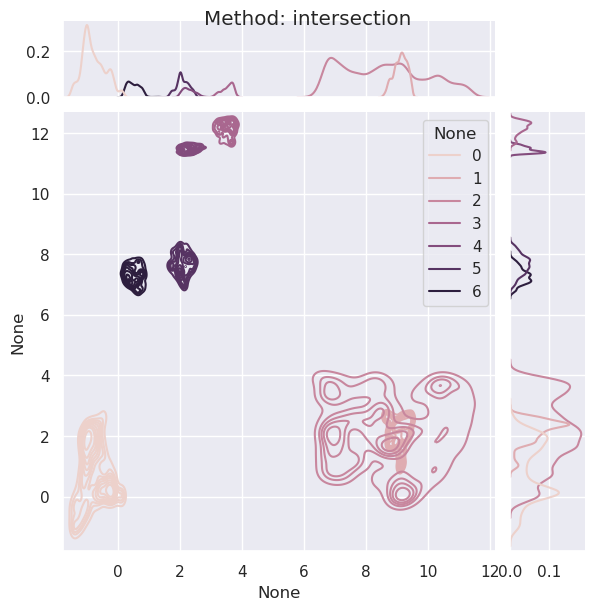

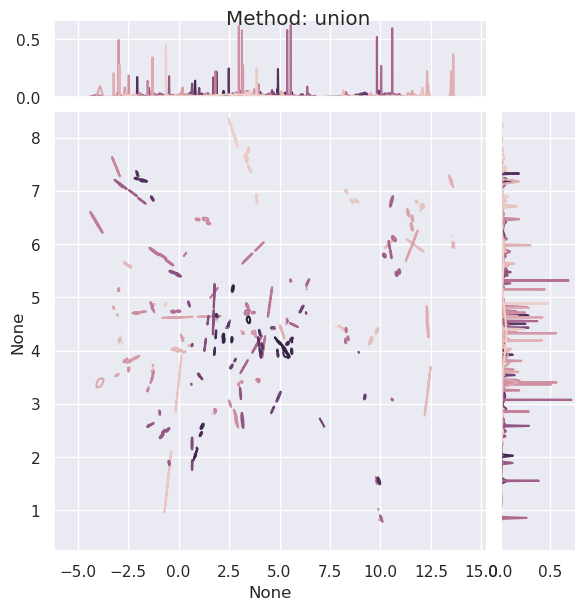

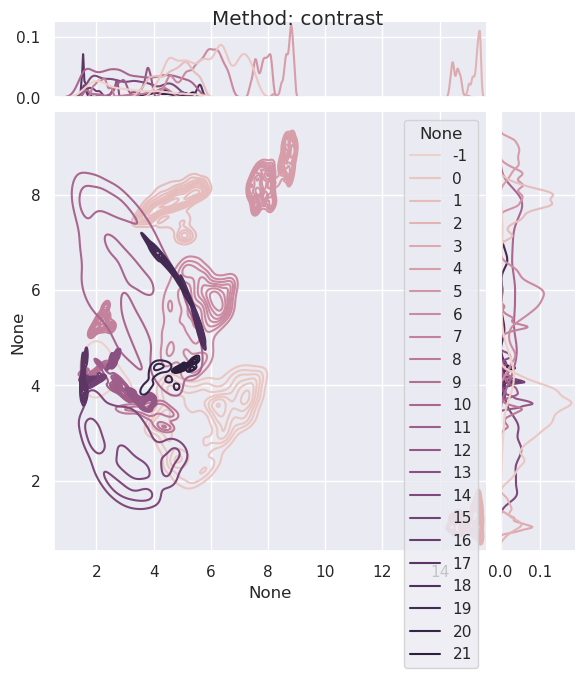

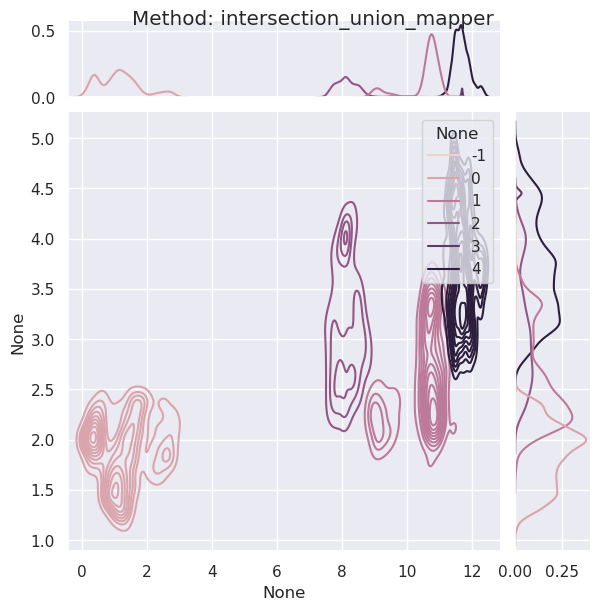

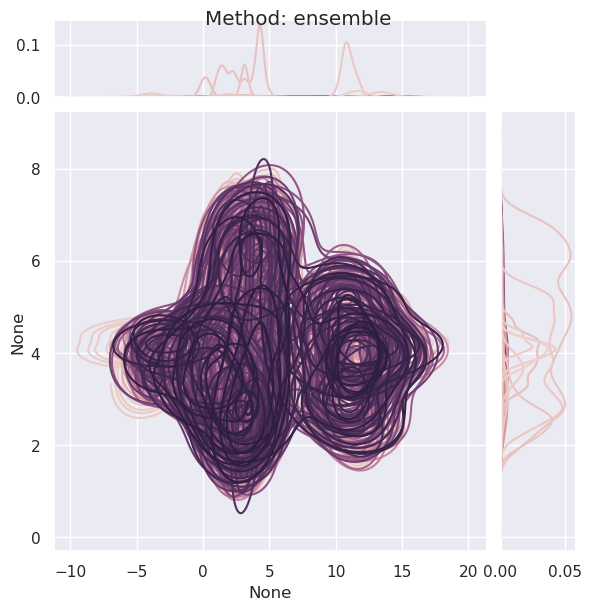

In [34]:
hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

for method in methods:
    print(f"Running method using: {method}")
    clf = DenseClus(random_state=SEED, umap_combine_method=method, hdbscan_params=hdbscan_params)
    clf.fit(df)
    clusters = clf.evaluate()
    n_clusters = len(np.unique(clusters))
    print(f"Number of clusters: {n_clusters}")

    if hasattr(clf, "mapper_"):
        embeddings = clf.mapper_.embedding_
    else:
        embeddings = clf.numerical_umap_.embedding_

    joint_plot = sns.jointplot(
        x=embeddings[:, 0], y=embeddings[:, -1], hue=clusters, kind="kde", marginal_ticks=True
    )
    joint_plot.fig.suptitle(f"Method: {method}")
    if n_clusters > 50:
        joint_plot.ax_joint.legend_.remove()

    print("-" * 30)

----------
As a recap the steps that happened are:

1) Numerical features were taken out and then reduced into a *dense* UMAP embedding

2) Categorical features got extracted and learned into a *dense* separate UMAP embedding

3) The two embeddings were then combined with one of the available operations ("intersection", "union", "contrast", "intersection_union_mapper", "ensemble")

4) HDBSCAN uses density-based spatial clustering to hierarchical-fashion to extract clusters from the combined space

All of these features are now attached as usable `DenseClus` object. 

----------
## Analysis:

Based on the above results for each method: `intersection_union_mapper` seems to be the suitable method for clustering our dataset. As you can see we have 5 distinct islands formed within the slice of the data. Clusters have formed around these densities which is exactly the behavior we expect DenseClus to do.

`Intersection_union_mapper` is a hybrid method that combines the strengths of both 'intersection' and 'union'. It first applies the 'intersection' method to preserve the numerical embeddings, then applies the 'union' method to preserve the categorical embeddings. This method is useful when both numerical and categorical data are important, but one type of data is not necessarily more important than the other.

Let's dive deep into Embedding Results for the intersection_union_mapper method:

In [35]:
clf = DenseClus(random_state=SEED, umap_combine_method="intersection_union_mapper")

clf.fit(df)

In [36]:
# let's confirm that the majority of data points are covered by our clusters and the DBCV score.
labels = clf.evaluate()

DBCV score 0.6093614712111133
Coverage 0.994287644728356


## Checking Embedding Results

Verify the embeddings are now densely shaped.

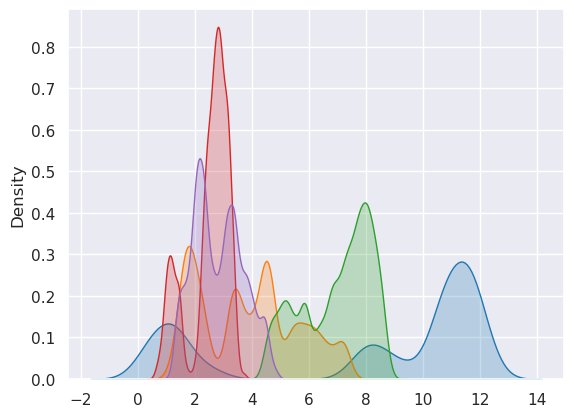

In [37]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

### Inspection of Cluster Results

Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [38]:
cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

   cluster  count
4       -1    186
1        0   9123
2        1   8647
3        2   4109
5        3    109
0        4  10387


Upon examination there are exactly 5 clusters with -1 representing the noise found in the data.

### Profiling the Clusters

Finally, once clusters are formed, it's common practice to then describe what each one means.

Here, descriptive statistics is actually a very powerful (and efficient) tool to use.

In [39]:
df["segment"] = labels

numerics = df.select_dtypes(include=[int, float]).drop(labels=["segment"], axis=1).columns.tolist()

df[numerics + ["segment"]].groupby(["segment"]).mean()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
segment,,,,,,
-1,35.924731,226824.677419,8.661290,895.118280,335.252688,44.935484
0,40.477255,187012.013263,13.329935,2463.276006,138.065877,43.102050
1,36.201688,187976.106048,10.156124,620.934197,71.266219,39.259512
2,38.357265,200116.851789,5.558530,254.536140,51.286201,36.449988
3,32.339450,195018.385321,9.000000,117.651376,12.917431,40.504587
4,39.099836,188900.247232,8.989699,579.804948,66.658901,40.573890


Let's ignore group `-1`.

Let's generate a profile for each of the segment, we can see that:
- Segment 0 has the oldest, most educated, and highest earning individuals working full-time. 
- Segment 1 has slightly younger, moderately educated, middle earning individuals working part-time.  
- Segment 2 has middle aged, less educated, moderate earning individuals working part-time.
- Segment 3 has the youngest, moderately educated, middle earning individuals working full-time.
- Segment 4 has older, less educated, lower earning individuals working full-time.


This is just profiling but descriptive statistics are revealing of what patterns are captured.

A similar type of analysis is possible with categorical features, with a reference shown below.

In [40]:
categorical = df.select_dtypes(include=["object"])

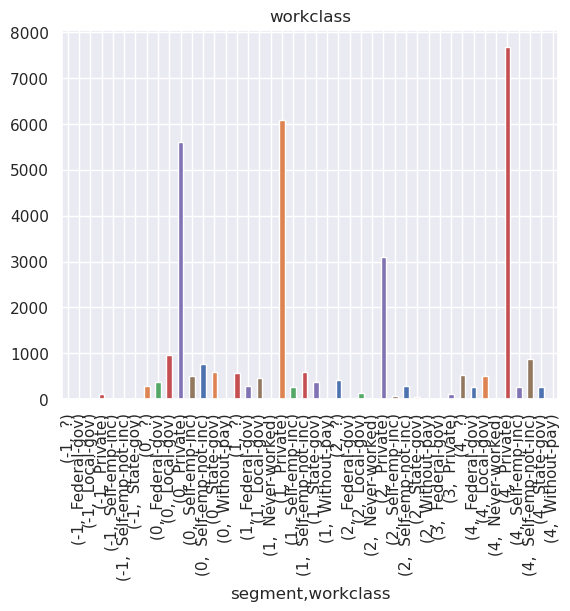

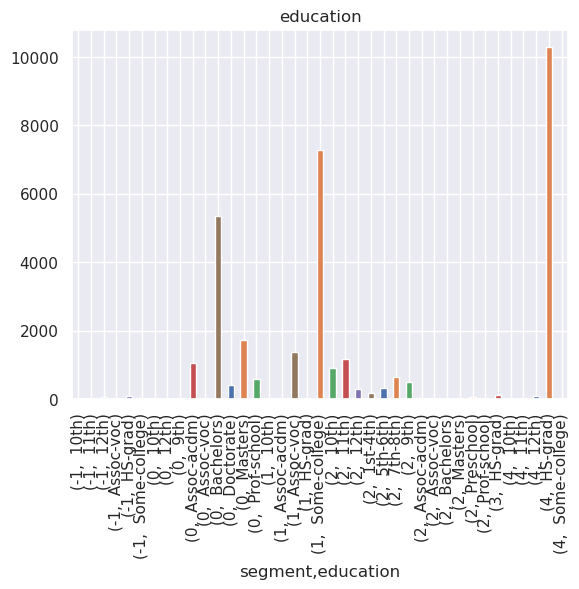

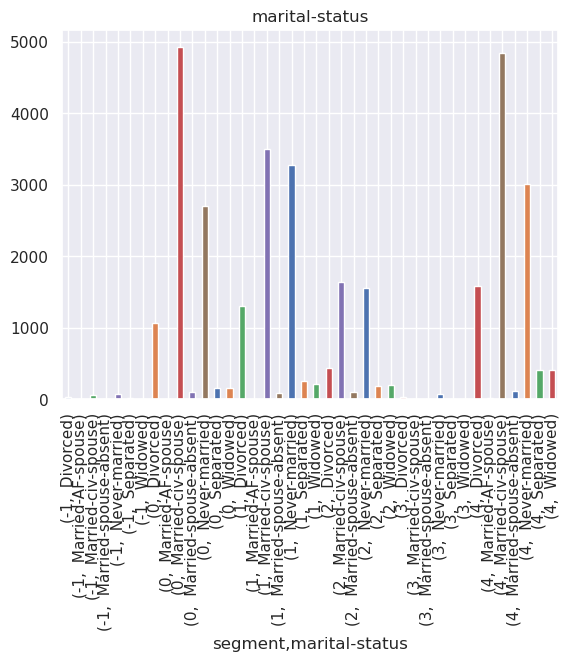

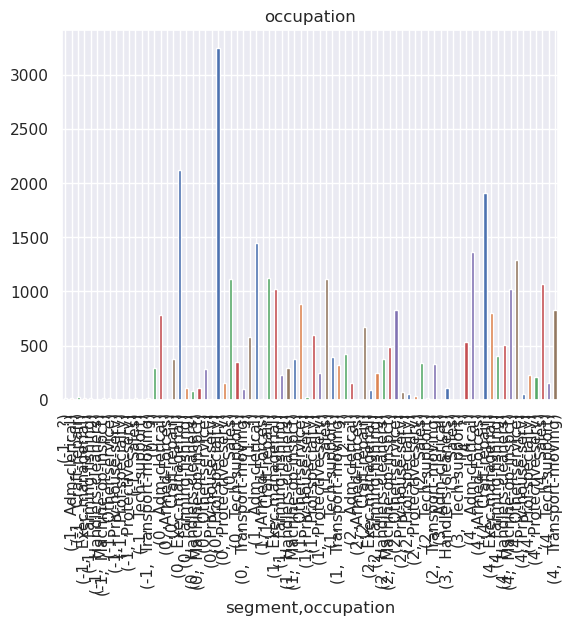

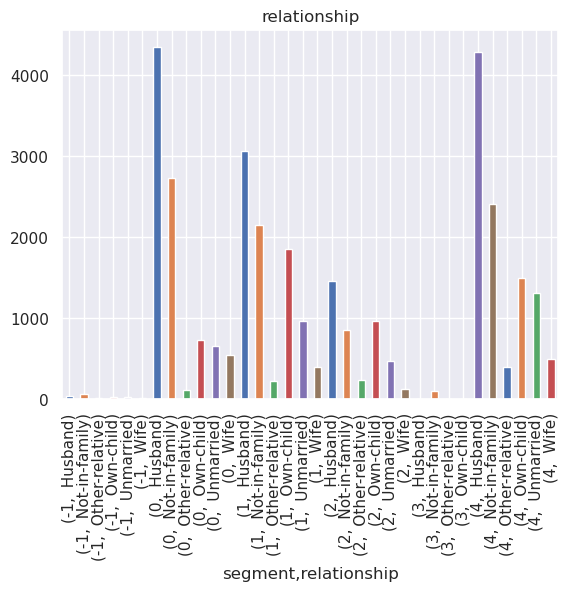

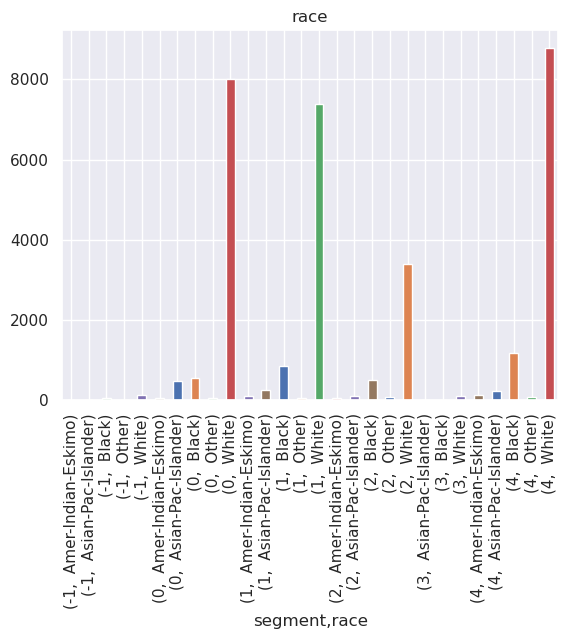

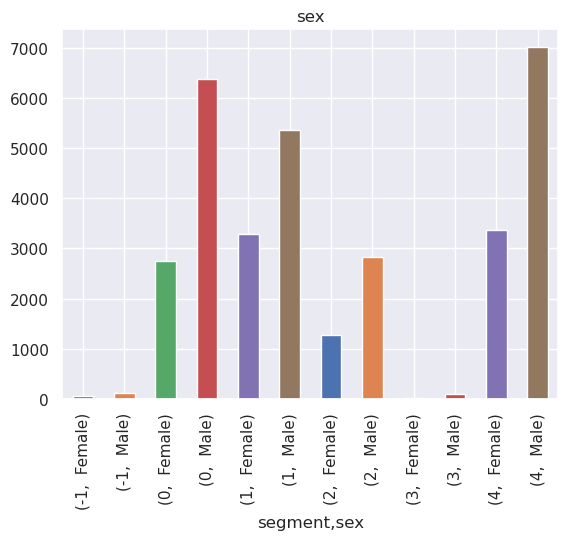

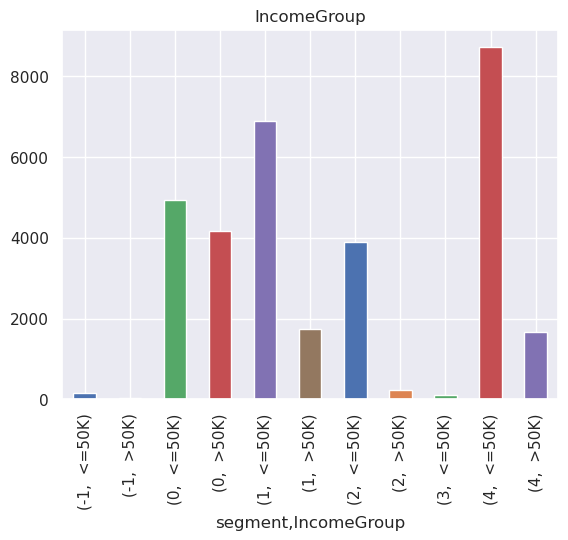

In [41]:
for c in categorical.columns:
    df.groupby(["segment"] + [c]).size().plot(
        kind="bar", color=sns.color_palette("deep", np.unique(labels).shape[0])
    )
    plt.title(c)
    plt.show()

## Conclusion

I hoped you enjoyed a closer look at DenseClus implementation!!

In this post you looked at 5 different methods for combining umaps, namely "intersection", "union", "contrast", "intersection_union_mapper", "ensemble". We implemented all the 5 methods for the census dataset and compared the clustered results using DBCV score and vislualization of its embeddings. 

For this particular dataset, we learned that "intersection_union_mapper" was able to create 5 distinct islands around the densities which is exactly the behavior we expect DenseClus to do. 

Feel free to experiment with the umap_combine_method and the hdbscan parameters to see which works best for your dataset. 